<a href="https://colab.research.google.com/github/vaishnavivyasam/Vaishnavi_INFO5731_Fall2021/blob/main/INFO5731_Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 

In [53]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools

!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

import pyLDAvis.gensim_models as gensimvis

from gensim import corpora, models
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [54]:
# NLTK Stop words

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
import pandas as pd
df = pd.read_csv("sentimentanalysis.csv")
df_data = df['Review text']
df

,Document_id,Review text,Sentiment_Type
0,0,After 10 15 minutes of use my ears started b...,POSITIVE
1,1,I ordered these the 1st day they were availa...,NEGATIVE
2,2,I go to the gym and with these they were so ...,POSITIVE
3,3,Does not work properly with amazon music. Sl...,POSITIVE
4,4,NaN,NEUTRAL
...,...,...,...
495,495,"Perfect! Came brand new in the box, almost f...",POSITIVE
496,496,This was a gift for my son. He’s very happy ...,POSITIVE
497,497,While we have to wait and see the long term ...,POSITIVE
498,498,I normally don’t write reviews but I’ve spen...,NEGATIVE


In [56]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

df_data = list(sent_to_words(df_data))

print(df_data[:1])

[['after', 'minutes', 'of', 'use', 'my', 'ears', 'started', 'burning', 'when', 'got', 'home', 'noticed', 'that', 'had', 'bleeding', 'open', 'wounds', 'on', 'my', 'ears', 'located', 'where', 'the', 'airpods', 'rest', 'glad', 'wasn', 'more', 'seriously', 'injured', 'the', 'pain', 'continued', 'for', 'over', 'hours', 'even', 'after', 'washing', 'the', 'area']]


In [57]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df_data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[df_data[0]]])

['after', 'minutes', 'of', 'use', 'my', 'ears', 'started', 'burning', 'when', 'got', 'home', 'noticed', 'that', 'had', 'bleeding', 'open', 'wounds', 'on', 'my', 'ears', 'located', 'where', 'the', 'airpods', 'rest', 'glad', 'wasn', 'more', 'seriously', 'injured', 'the', 'pain', 'continued', 'for', 'over', 'hours', 'even', 'after', 'washing', 'the', 'area']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [58]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [59]:
# Remove Stop Words
data_words_nostops = remove_stopwords(df_data)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['minute', 'ear', 'start', 'burn', 'get', 'home', 'notice', 'bleed', 'open', 'wound', 'ear', 'locate', 'airpod', 'rest', 'seriously', 'injure', 'pain', 'continue', 'hour', 'even', 'wash', 'area']]


In [60]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [61]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [62]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.122*"spend" + 0.122*"scamme" + 0.122*"pod" + 0.122*"air" + 0.122*"money" '
  '+ 0.122*"fake" + 0.122*"get" + 0.122*"son" + 0.000*"say" + 0.000*"ear"'),
 (1,
  '0.006*"still" + 0.006*"subscription" + 0.006*"people" + 0.006*"perfectly" + '
  '0.006*"ploy" + 0.006*"pretty" + 0.006*"properly" + 0.006*"randomly" + '
  '0.006*"solely" + 0.006*"speed"'),
 (2,
  '0.006*"son" + 0.006*"money" + 0.006*"pod" + 0.006*"air" + 0.006*"scamme" + '
  '0.006*"spend" + 0.006*"fake" + 0.006*"get" + 0.006*"long" + 0.006*"seem"'),
 (3,
  '0.157*"music" + 0.079*"work" + 0.052*"fine" + 0.052*"apple" + 0.026*"ploy" '
  '+ 0.026*"people" + 0.026*"must" + 0.026*"perfectly" + 0.026*"properly" + '
  '0.026*"pretty"'),
 (4,
  '0.006*"ear" + 0.006*"say" + 0.006*"get" + 0.006*"son" + 0.006*"love" + '
  '0.006*"good" + 0.006*"really" + 0.006*"complaint" + 0.006*"dog" + '
  '0.006*"perfectly"'),
 (5,
  '0.006*"wait" + 0.006*"term" + 0.006*"hopefully" + 0.006*"huge" + '
  '0.006*"improvement" + 0.006*"buying" +

In [63]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.7729276997705856

Coherence Score:  0.5127556445357581


In [65]:
# Topic 10 cluster using LDA
lDmodel = models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics = 10, 
                                   random_state=100,update_every=1,chunksize=100,
                                   passes=10,alpha='auto',per_word_topics=True)
from pprint import pprint
pprint(lDmodel.print_topics())
IDM1 = lDmodel[corpus]

[(0,
  '0.150*"say" + 0.075*"son" + 0.075*"dog" + 0.075*"love" + 0.075*"really" + '
  '0.075*"run" + 0.075*"complaint" + 0.075*"good" + 0.075*"ear" + '
  '0.075*"perfectly"'),
 (1,
  '0.006*"apple" + 0.006*"music" + 0.006*"still" + 0.006*"subscription" + '
  '0.006*"ploy" + 0.006*"pretty" + 0.006*"properly" + 0.006*"randomly" + '
  '0.006*"solely" + 0.006*"speed"'),
 (2,
  '0.120*"son" + 0.120*"get" + 0.120*"money" + 0.120*"spend" + 0.120*"fake" + '
  '0.120*"scamme" + 0.120*"pod" + 0.120*"air" + 0.000*"say" + 0.000*"good"'),
 (3,
  '0.119*"music" + 0.060*"work" + 0.040*"apple" + 0.040*"fine" + 0.020*"ploy" '
  '+ 0.020*"people" + 0.020*"must" + 0.020*"airpod" + 0.020*"properly" + '
  '0.020*"pretty"'),
 (4,
  '0.006*"ear" + 0.006*"get" + 0.006*"son" + 0.006*"say" + 0.006*"good" + '
  '0.006*"money" + 0.006*"fake" + 0.006*"scamme" + 0.006*"spend" + '
  '0.006*"pod"'),
 (5,
  '0.049*"music" + 0.029*"update" + 0.029*"apple" + 0.020*"back" + '
  '0.020*"call" + 0.020*"charge" + 0.020*"mic

In [66]:
#Topic 10 cluster using LSA
lSamodel = models.LsiModel(corpus, num_topics = 10, id2word = id2word)
pprint(lSamodel.print_topics(num_topics = 10))

[(0,
  '0.505*"music" + 0.268*"apple" + 0.206*"update" + 0.164*"glitch" + '
  '0.164*"slow" + 0.145*"issue" + 0.145*"turn" + 0.140*"minute" + '
  '0.139*"charge" + 0.138*"go"'),
 (1,
  '0.480*"music" + 0.354*"work" + 0.236*"fine" + -0.136*"update" + 0.121*"get" '
  '+ 0.119*"perfectly" + 0.118*"mostly" + 0.118*"annoy" + 0.118*"must" + '
  '0.118*"apps"'),
 (2,
  '0.291*"save" + 0.291*"time" + 0.291*"try" + 0.165*"airpod" + 0.163*"hour" + '
  '0.158*"spend" + 0.158*"money" + 0.158*"fake" + 0.156*"brand" + 0.156*"box"'),
 (3,
  '0.438*"ear" + 0.203*"get" + 0.197*"seriously" + 0.197*"burn" + 0.197*"open" '
  '+ 0.197*"notice" + 0.197*"injure" + 0.197*"home" + 0.197*"pain" + '
  '0.197*"bleed"'),
 (4,
  '-0.498*"say" + -0.282*"good" + -0.280*"son" + -0.250*"dog" + -0.250*"stay" '
  '+ -0.250*"run" + -0.250*"really" + -0.250*"sound" + -0.250*"complaint" + '
  '-0.250*"love"'),
 (5,
  '0.289*"wait" + 0.289*"huge" + 0.289*"discount" + 0.289*"improvement" + '
  '0.289*"long" + 0.289*"see" + 0.

# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("sentimentanalysis.csv")
df_data = df['Review text']
df.head()

,Document_id,Review text,Sentiment_Type
0,0,After 10 15 minutes of use my ears started b...,POSITIVE
1,1,I ordered these the 1st day they were availa...,NEGATIVE
2,2,I go to the gym and with these they were so ...,POSITIVE
3,3,Does not work properly with amazon music. Sl...,POSITIVE
4,4,NaN,NEUTRAL


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(df['Review text'].apply(lambda x: np.str_(x)))
y = df['Sentiment_Type']


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
cm = MultinomialNB()
cm.fit(x_train,y_train)
y_pred = cm.predict(x_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_valid,y_pred))

Accuracy: 100.00%
              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        26
     NEUTRAL       1.00      1.00      1.00        21
    POSITIVE       1.00      1.00      1.00        53

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        24
     NEUTRAL       1.00      1.00      1.00        20
    POSITIVE       1.00      1.00      1.00        56

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/info5731_spring2021/blob/main/assignment/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 

In [ ]:
import pandas as pd
df_test = pd.read_csv("test.csv")
df_train= pd.read_csv("train.csv")
df_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [ ]:
df_test.YrSold.min(), df_test.YrSold.max()

(2006, 2010)

In [ ]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
df_train.YrSold.min(), df_train.YrSold.max()

(2006, 2010)

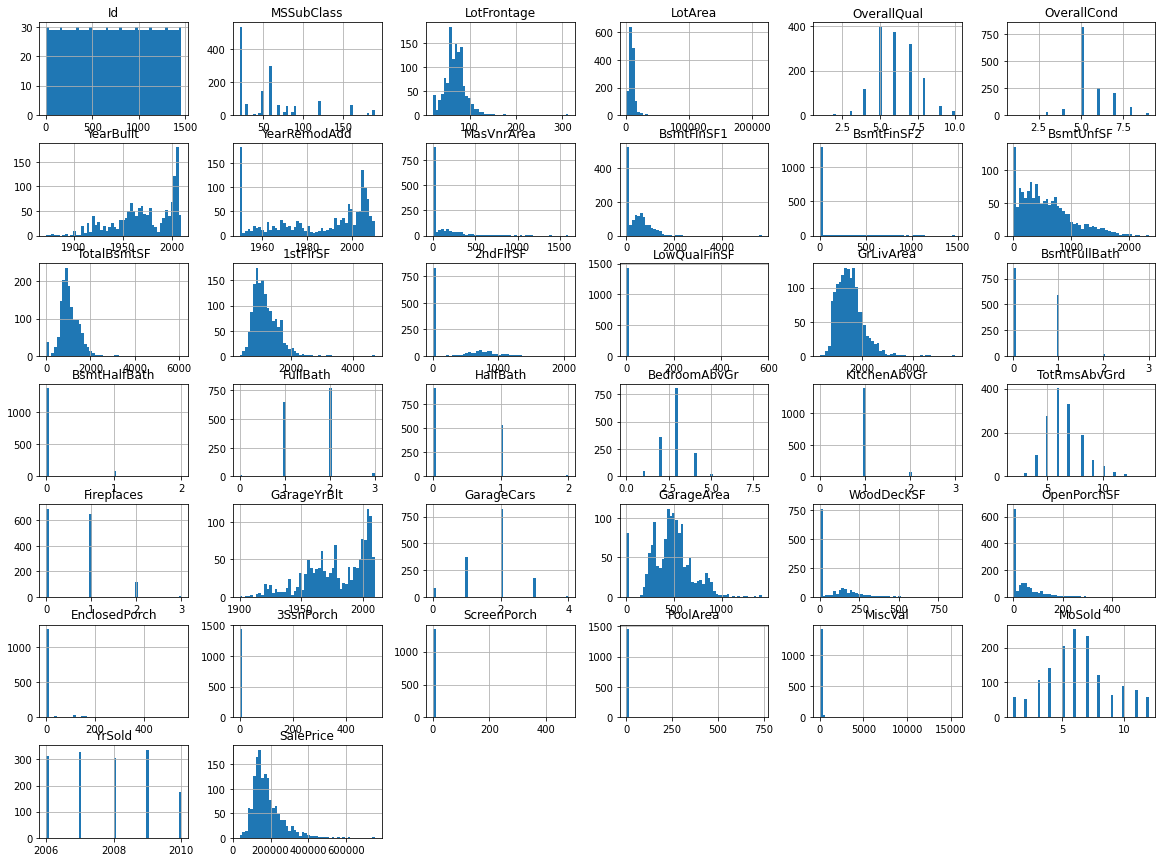

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
df_train.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [ ]:
#Correlation matrix for the sold prices
corr_matrix = df_train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

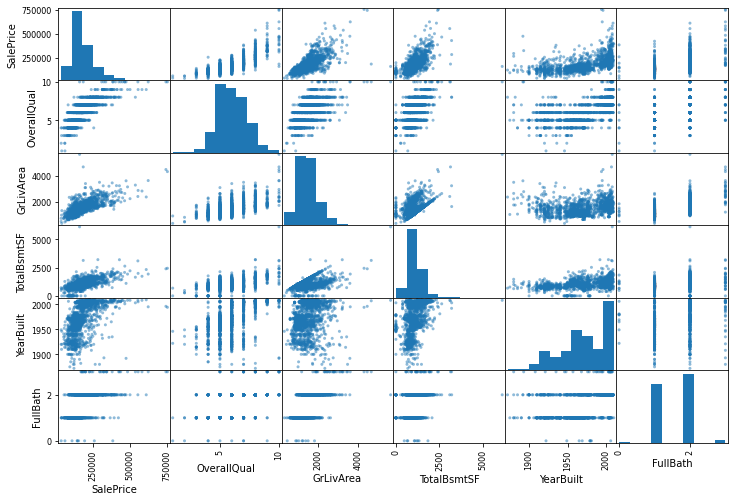

In [ ]:
from pandas.plotting import scatter_matrix
#from pandas.tools.plotting import scatter_matrix
attributes = ["SalePrice", "OverallQual", "GrLivArea", "TotalBsmtSF", "YearBuilt", "FullBath"]
scatter_matrix(df_train[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

In [ ]:
df_train.fillna(df_train.mean(), inplace = True)
df_test.fillna(df_test.mean(), inplace = True)

In [ ]:
print(df_train.isnull().sum())

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64


In [ ]:
print(df_test.isnull().sum())

Id               0
MSSubClass       0
MSZoning         4
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         1
SaleCondition    0
Length: 80, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn import metrics

cols = ('MSSubClass', 'Alley', 'SaleCondition', 'MasVnrType', 'SaleType', 'Foundation', 'Heating', 'GarageType', 'Electrical', 'Exterior1st', 'Exterior2nd', 'RoofMatl', 'FireplaceQu', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'Utilities', 'BldgType', 'GarageFinish','PoolQC', 'BsmtQual', 'BsmtCond', 'GarageQual','BsmtExposure', 'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1','BsmtFinType2', 'Functional', 'Fence', 'HouseStyle', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'RoofStyle', 'CentralAir', 'GarageCond', 'OverallCond', 'YrSold', 'MoSold', 'MSZoning')
for i in cols:
    end = LabelEncoder()
    end.fit(list(df_train[i].values))
    df_train[i] = end.transform(list(df_train[i].values))
X = df_train[df_train.columns[:80]]
Y = df_train['SalePrice']    
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2)
reg = LinearRegression()  
reg.fit(X_train, Y_train)
Pred_House = reg.predict(X_test)
print("R-Square value: ", reg.score(X_train,Y_train))

R-Square value:  0.8908735296397224


In [ ]:
print(pd.DataFrame({'predicted Sales Prices':Pred_House}))

     predicted Sales Prices
0             280062.005875
1              82179.913837
2              78122.628702
3              51796.960538
4             209909.605160
..                      ...
287           114901.514769
288           169400.322879
289           219643.170301
290           254618.731420
291           139855.640886

[292 rows x 1 columns]
